In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMModel
from os import path
from sklearn.metrics import mean_squared_error

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.10f' % x)

In [45]:
data_dir = '../datasets'

if not path.exists(data_dir):
    raise Exception('{} directory not found.'.format(data_dir))

# lgbm_val_file = '{}/{}'.format(data_dir, 'lgbm_pred_val.zip')
# print('\nLGBM Val Prediction file: {}'.format(lgbm_val_file))

lgbm_test_file = '{}/{}'.format(data_dir, 'lgbm_pred_test.zip')
print('\nLGBM Test Prediction file: {}'.format(lgbm_test_file))

# lstm_val_file = '{}/{}'.format(data_dir, 'lstm_pred_val.zip')
# print('\nLSTM Val Prediction file: {}'.format(lstm_val_file))

lstm_test_file = '{}/{}'.format(data_dir, 'lstm_pred_test.zip')
print('\nLSTM Test Prediction file: {}'.format(lstm_test_file))


LGBM Test Prediction file: ../datasets/lgbm_pred_test.zip

LSTM Test Prediction file: ../datasets/lstm_pred_test.zip


In [46]:
def load_data(zip_path):
    df = pd.read_csv(
        zip_path,
        dtype={'fullVisitorId': 'str'},
        compression='zip'
    )
    
    [rows, columns] = df.shape

    print('Loaded {} rows with {} columns from {}.'.format(
        rows, columns, zip_path
    ))
    
    return df

In [114]:
%%time

# lstm_val_df = load_data(lstm_val_file)
lstm_test_df = load_data(lstm_test_file)

# lgbm_val_df = load_data(lgbm_val_file)
lgbm_test_df = load_data(lgbm_test_file)

print()
# comparison_df = df = pd.read_csv(
#         comp_file,
#         dtype={'fullVisitorId': 'str'},
#     )

# print(comparison_df.shape)

Loaded 617242 rows with 2 columns from ../datasets/lstm_pred_test.zip.
Loaded 617242 rows with 2 columns from ../datasets/lgbm_pred_test.zip.

CPU times: user 938 ms, sys: 218 ms, total: 1.16 s
Wall time: 1.28 s


In [121]:
merged_test = pd.merge(lgbm_test_df, lstm_test_df, on='fullVisitorId')
merged_test = merged_test.rename(columns={'predictedRevenue_y': 'lstm', 'predictedRevenue_x': 'lgbm'})

merged_test['is_lstm_higher'] = np.where(
    (merged_test['lstm'] > merged_test['lgbm']), 
    True, 
    False
)

merged_test['is_lgbm_higher'] = np.where(
    (merged_test['lstm'] < merged_test['lgbm']), 
    True, 
    False
)

merged_test['both_equal'] = np.where(
    (merged_test['lstm'] == merged_test['lgbm']), 
    True, 
    False
)

merged_test.head()


,fullVisitorId,lgbm,lstm,is_lstm_higher,is_lgbm_higher,both_equal
0,0000000259678714014,2.3897294998,38.9576300000,True,False,False
1,0000049363351866189,0.0874586600,0.0000000000,False,True,False
2,0000053049821714864,0.0000000000,0.0000000000,False,False,True
3,0000059488412965267,1.9629093950,0.0000000000,False,True,False
4,0000085840370633780,0.1048852054,0.0048613310,False,True,False


In [122]:
merged_test.shape
merged_test.groupby('is_lstm_higher').size() 

lstm_high = merged_test[merged_test['is_lstm_higher'] == True]
lgbm_high = merged_test[merged_test['is_lgbm_higher'] == True]
both_equal = merged_test[merged_test['both_equal'] == True]


print('lstm_high::', lstm_high.shape)
print('lgbm_high::', lgbm_high.shape)
print('both_equal::', both_equal.shape)

lstm_high:: (190980, 6)
lgbm_high:: (216631, 6)
both_equal:: (209631, 6)


Text(0, 0.5, 'predictedRevenue')

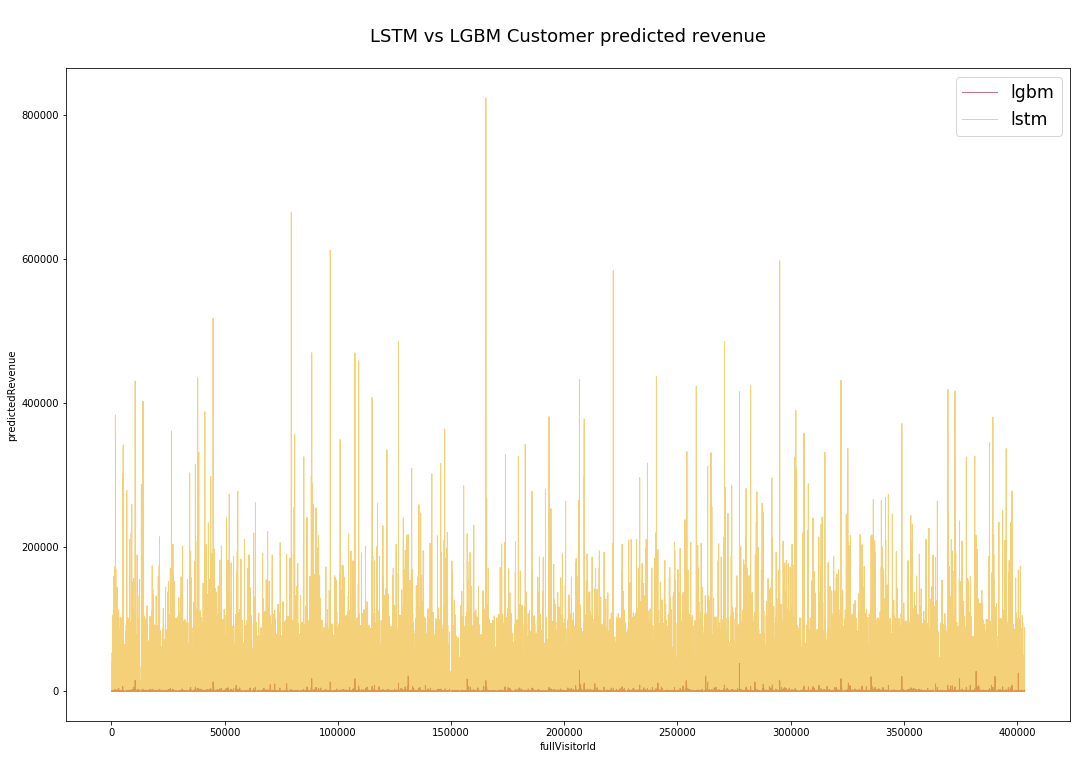

In [113]:
plt.figure(figsize=(18, 12))

df=pd.DataFrame({
    'x': range(1, lstm_high.shape[0] + 1), 
    'lgbm': lstm_high['lgbm'].values, 
    'lstm': lstm_high['lstm'].values
})
  
palette = [[0.6350, 0.0780, 0.1840], [0.9290, 0.6940, 0.1250]]
 
for idx, column in enumerate(df.drop('x', axis=1)):
    plt.plot(df['x'], df[column], marker='', color=palette[idx], linewidth=1, alpha=0.6, label=column)


plt.legend(fontsize='xx-large')
plt.title(
    '\nLSTM vs LGBM Customer predicted revenue\n', 
    fontsize=18
)
plt.xlabel('fullVisitorId')
plt.ylabel('predictedRevenue')
